# Dataset Loading

In this notebook, you can test the dataset loading needed for the training script.
It should help you to check whether all the steps have been followed correctly and paths are specified correctly.

In [1]:
from src.logging.visualization import Demo
import torch
torch.cuda.set_device(0)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

### Configuration File Loading

The configuration file `configs/demo_data_loading`should specify the dataset and featurizer. In order to test multiple configurations, you can change the file accordingly.

In [2]:
from hydra import compose, initialize
with initialize(config_path="./configs", job_name="test_app"):
    args = compose(config_name="demo_data_loading")

### Dataset Loading

First, we will load the datasat specified in the configutation file. The supervision mode determines whether augmentations are used.

In [4]:
from src.dataset.spair import SpairDataset2
from src.dataset.cub_200_pairs import CUBPairDataset
from src.dataset.pfpascal_pairs import PFPascalPairs
from src.dataset.apk_pairs import AP10KPairs
if args.dataset.name == 'spair':
    dataset = SpairDataset2(args.dataset, split='train')
elif args.dataset.name == 'cub':
    dataset = CUBPairDataset(args.dataset, split='train')
elif args.dataset.name == 'pfpascal':
    dataset = PFPascalPairs(args.dataset, split='train')
elif args.dataset.name == 'ap10k':
    dataset = AP10KPairs(args.dataset, split='train')
print(f"Dataset: {args.dataset}")
print(f"Supervision Mode: {args.dataset.sup}")

Dataset: {'name': 'spair', 'dataset_path': '<your_dataset_path>/SPair-71k', 'save_path': '<your_precomputed_features_path>', 'save_path_masks': '<your_precomputed_masks_path>', 'hydra': {'output_subdir': None}, 'sup': 'sup_augmented', 'flip_aug': True, 'cat': 'all'}
Supervision Mode: sup_augmented


### Category Selection

The category can be changed according to the dataset at hand.

In [5]:
print(f"All Categories: {dataset.all_cats}")
cat = "dog"
dataset.init_kps_cat(cat)
print(f"Chosen Category: {cat}")

All Categories: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'train', 'tvmonitor']
Chosen Category: dog


# 1. Annotated Data
Now, we will check whether the annotation is available in the dataset. Specifically, we will load the keypoints and display them. Next, we will also check whether the `get_matches` function correctly provides the three different pairs of pairwise keypoint annotation.

### Keypoint data per image
Here, we check whether we can correctly load the keypoint annotation and display it.

In [6]:
dataset.return_imgs = True
dataset.return_feats = False
def init_demo_data(dataset, idx):
    dataset.return_kps = True
    dataset.return_imgs = True
    dataset.return_feats = False
    dataset.seed = 1
    data = dataset[idx]
    imgs = [data['src_img'], data['trg_img']]
    img_size = [data['src_imsize'], data['trg_imsize']]
    demo = Demo(imgs, None, img_size)
    return demo, data
idx = 0
demo, data = init_demo_data(dataset, 0)
print(f"Augmentatation by flipping:\n\tsrc_img={data['src_hflip']}\n\ttrg_img={data['trg_hflip']}")

Augmentatation by flipping:
	src_img=False
	trg_img=False


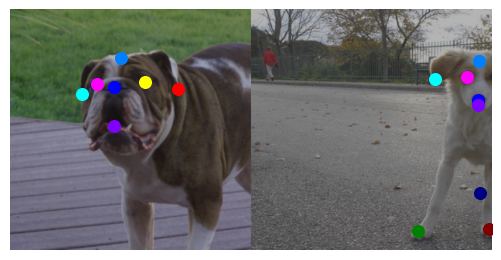

In [7]:
%matplotlib inline
demo.plot_matches(data['src_kps'], data['trg_kps'], fig_size=3, alpha=0.45, scatter_size=70)

### Keypoint data for an image pair
Now, we will check the annotation necessary for training.
We have 
- negative pairs,
- positive pairs, and
- bin pairs, i.e. where a keypoint is occluded in one view.

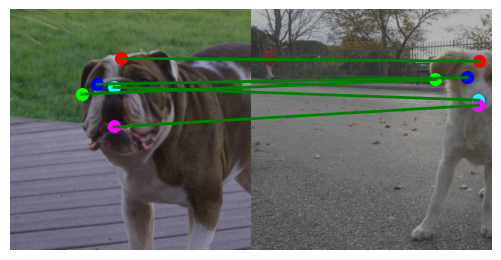

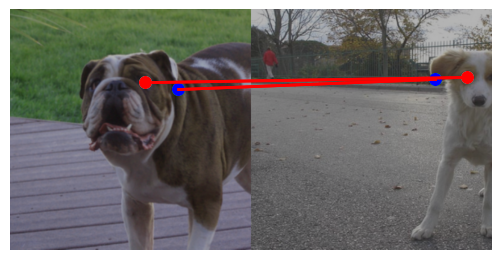

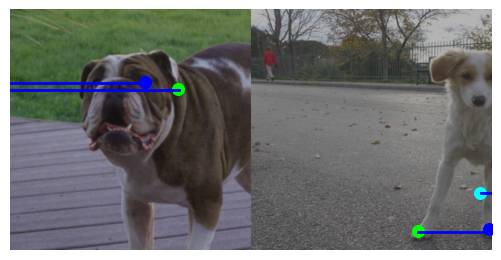

In [8]:
from src.dataset.pairwise_utils import get_matches
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
%matplotlib inline
# data from dataloader differs from data from dataset due to batch size and conversion to tensor
for idx_, data in enumerate(loader):
    if idx_ == idx:
        break
data_matches = get_matches(data, 0)
for prefix in['pos','neg', 'bin']:
    src_points = data_matches[prefix+'_src_kps']
    src_vis = src_points[:,2]>0.5
    trg_points = data_matches[prefix+'_trg_kps']
    trg_vis = trg_points[:,2]>0.5
    demo.plot_matches(src_points[src_vis], trg_points[trg_vis], fig_size=3, alpha=0.45, scatter_size=70, title=prefix)

# 2. Featurizer Initialization

Load the model, specified in the config file to receive the features. In case the function `scripts/store_feats.py` has already stored the preprocessed features on the disk, you can specify `preprocessed=True`.

In general, we cannot use pretrained features for training, as we are using a LoRA adapter as well as augmentation for training.
Therefore in general, we specify the featurizer directly and process images for each forward pass.
However, for testing the foundation models and especially for speeding up the evaluation of GEO, we recommend storing the features in advance.

In [9]:
from src.models.featurizer.utils import get_featurizer_name, get_featurizer

preprocessed = False # True if we want to use preprocessed features, which are already stored to disk
if preprocessed:
    featurizer_name = get_featurizer_name(args.featurizer)
    dataset.featurizer_name = featurizer_name
else:
    print(f"Memory allocated before loading: {torch.cuda.memory_allocated()//1024**3} GB")
    if args.featurizer.model == 'dift_sd':
        args.featurizer.all_cats = dataset.all_cats
    featurizer = get_featurizer(args.featurizer)
    dataset.featurizer = featurizer
    dataset.featurizer_kwargs = args.featurizer
    dataset.featurizer_name = featurizer.name
    print(f"Memory allocated after loading: {torch.cuda.memory_allocated()//1024**3} GB")
print(f"Featurizer: {dataset.featurizer_name}")

Memory allocated before loading: 0 GB


Using cache found in /dev/shm/hreg/cache/torch/hub/facebookresearch_dinov2_main


Memory allocated after loading: 0 GB
Featurizer: dinov2_b14_518_upft1


#### Test Feature Loading
Now let's check the availability of the features. We will create a plot, where we can click on one image and match the marked pixel to the second image.

In [10]:
dataset.return_feats = True
def init_demo(dataset, idx):
    data = dataset[idx]
    imgs = [data['src_img'], data['trg_img']]
    ft = [data['src_ft'][None], data['trg_ft'][None]]
    img_size = [data['src_imsize'], data['trg_imsize']]
    demo = Demo(imgs, ft, img_size)
    return demo, data
idx = 0
demo, data = init_demo(dataset, idx)

After clicking on the left image the attention map appears in the target view.

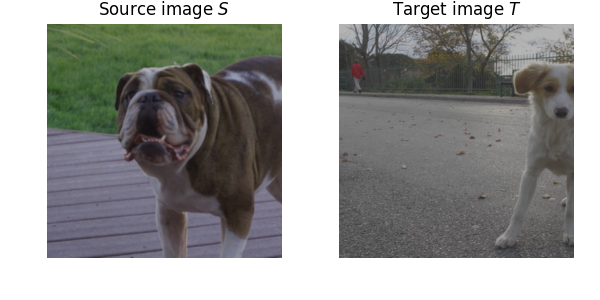

No such comm: 5c9f3933de64464d899167d6e8203725


In [11]:
%matplotlib widget
if args.featurizer.model != 'sd15ema_dinov2':
    demo.plot_img_pairs_click(upsample=True)
else:
    demo.plot_img_pairs_click(upsample=False)

# 3. Segmentation Mask

Define the segmentation model by `dataset.model_seg_name = 'sam'` to determine the path to the masks.
We assume that the store_masks.py script has already been running for mask extraction.

Memory allocated: 0 GB
aeroplane


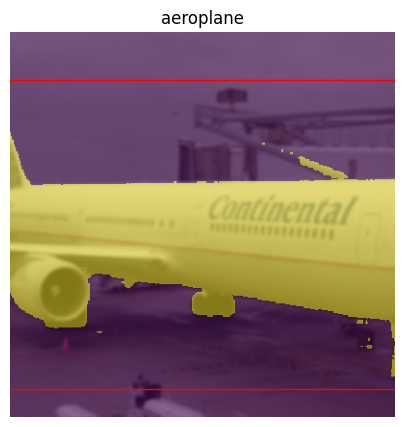

bicycle


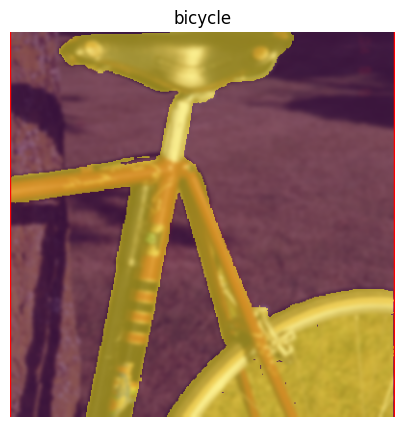

bird


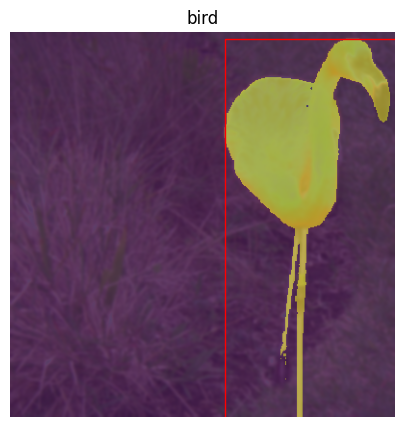

boat


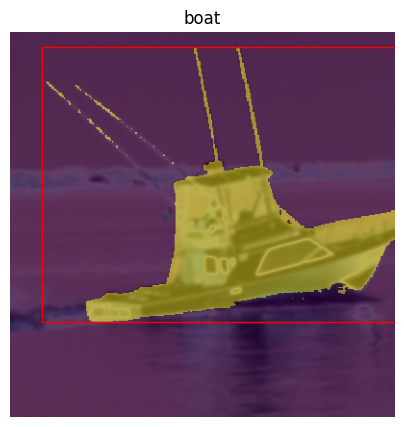

bottle


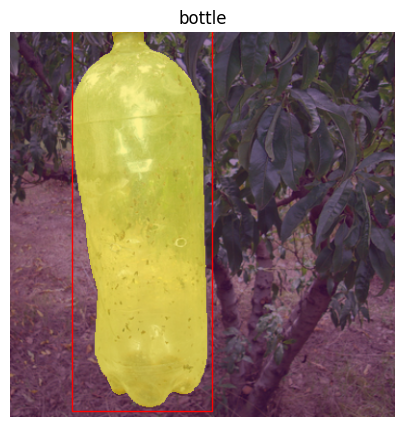

bus


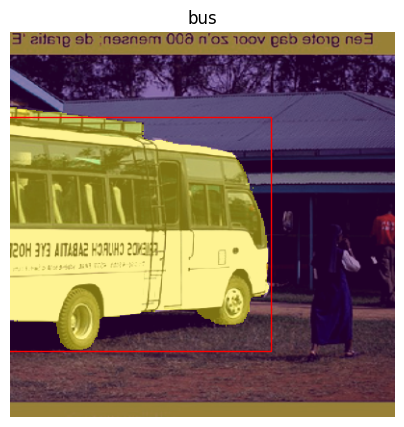

car


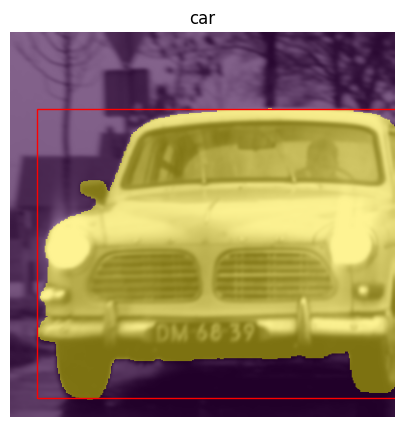

cat


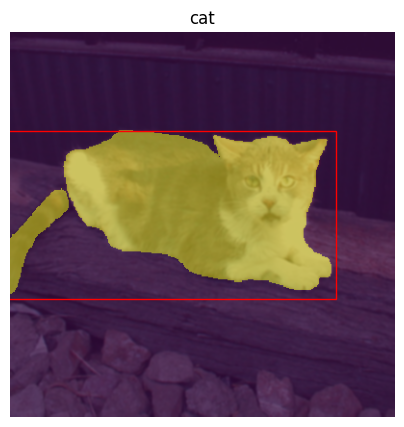

chair


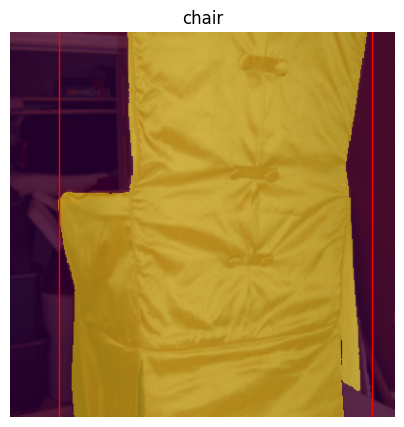

cow


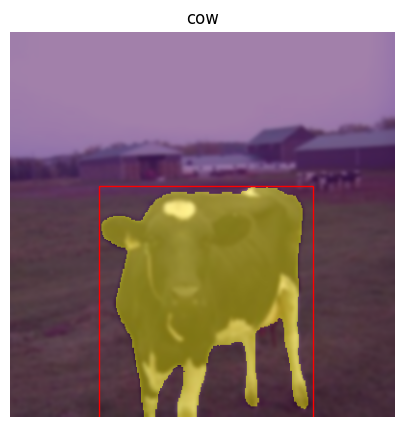

dog


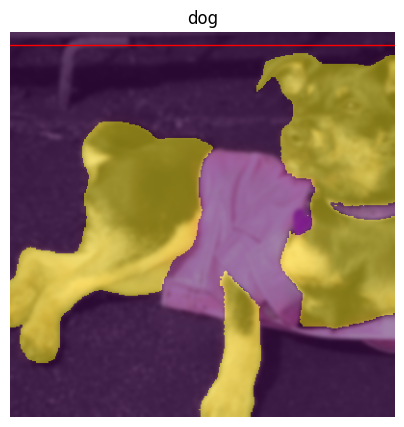

horse


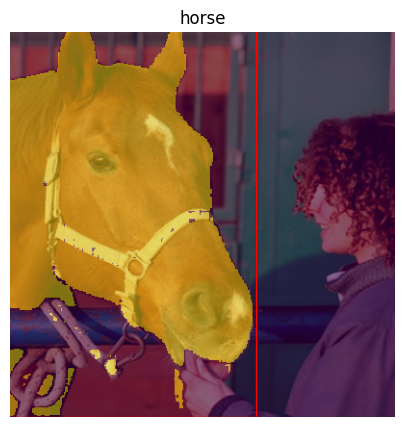

motorbike


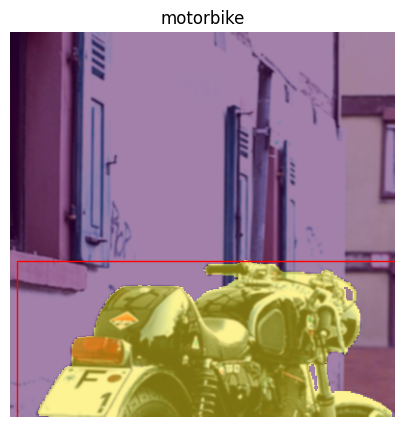

person


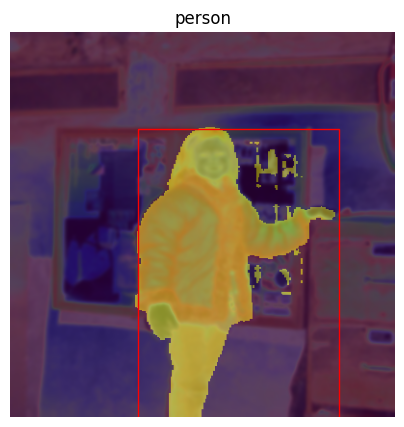

pottedplant


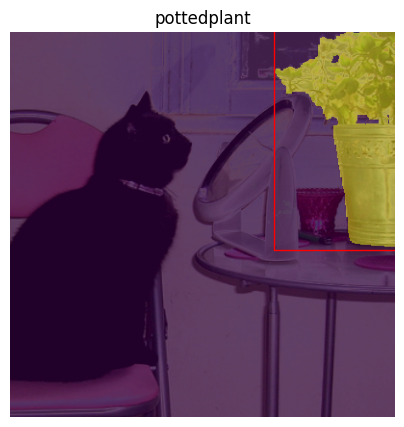

sheep


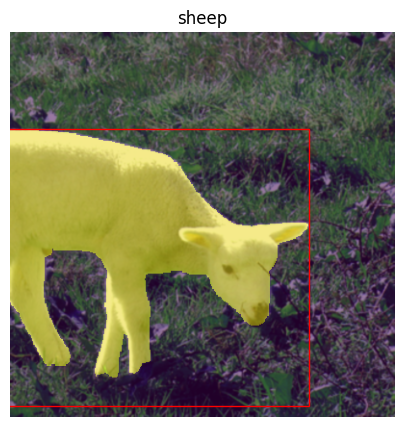

train


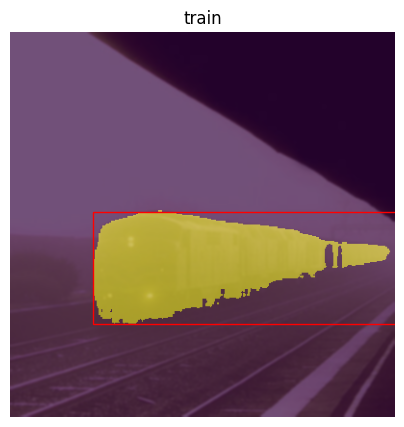

tvmonitor


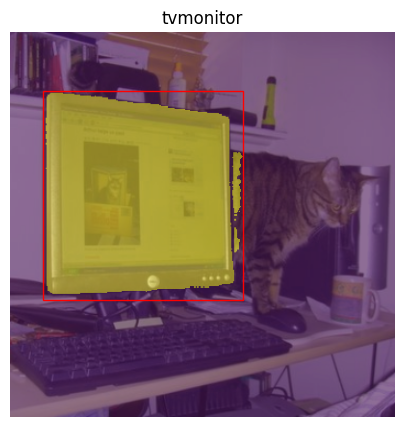

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from matplotlib.patches import Rectangle
%matplotlib inline

plt.close('all')
dataset.return_masks = True
dataset.model_seg_name = args.model_seg_name
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
idx = 1
print(f"Memory allocated: {torch.cuda.memory_allocated()//1024**3} GB")
for cat in dataset.all_cats:
    dataset.init_kps_cat(cat)
    print(cat)
    imsize = dataset[idx]['src_imsize']
    bbox = dataset[idx]['src_bndbox']
    prt = dataset[idx]['src_mask']
    im = dataset[idx]['src_img']

    fig = plt.figure(figsize=(5, 5))
    # show image
    im = dataset[idx]['src_img']
    plt.imshow(im)
    # plt the mask
    prt = np.array(prt)
    if prt.shape[0]!=imsize[0] or prt.shape[1]!=imsize[1]:
        prt = F.resize(F.to_pil_image(prt), (imsize[0],imsize[1]))
        prt = np.array(prt)
    plt.imshow(prt, alpha=0.5, cmap='viridis', vmin=0, vmax=1)
    # plot the boundingbox
    ax = plt.gca()
    rect = Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title(cat)
    plt.axis('off')
    plt.show()